In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from plots import *
from utils import *

# auto reload modules
%load_ext autoreload
%autoreload 2

# set line width
plt.rcParams['lines.linewidth'] = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Shorting Mature Peaks After MA Crossed for Fixed Number of Days

Whilst the naive moving average strategy suffers from the false positives, the mature peak and fixed short period strategy suffers from being either too late or too early. A strategy to try in thisi case wouldd be to combine the two strategies together.

We would wait for the moving average to cross, if the peak is mature enough, we would short for a fixed amount of time.

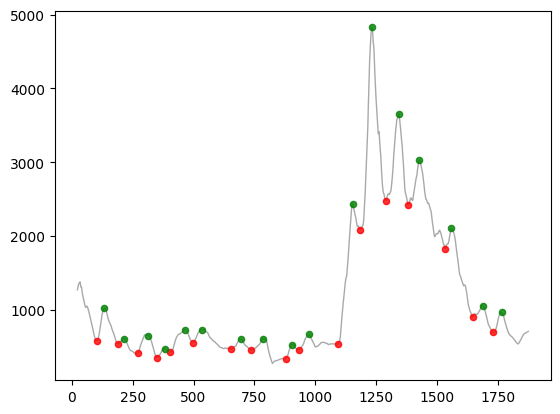

In [2]:
# load data
df = pd.read_csv('mkr_coinmarketcap.csv')
tp = pd.read_csv('mkr_ma24_troughs_and_peaks.csv')
tp = tp['troughs_and_peaks']
df['ma_24'] = df.usd.rolling(24).mean()
df['r'] = df['usd'].pct_change()

plot_peaks_throughs(df.ma_24, tp, s=20, alpha=0.8)

Train & Test Datasets:

In [4]:
train = df.iloc[:1000].copy()
train_tp = tp[tp < train.index[-1]].copy()
test = df.iloc[1000:].copy()

What is median peak age of 24d moving average in a training set?

In [5]:
train_troughs = train_tp[::2].values
train_peaks = train_tp[1::2].values

median_peak_age = int(np.median(train_peaks - train_troughs))
print(f'median peak age: {median_peak_age} days')

median peak age: 38 days


What is the histogram of peak ages?

(array([4., 1., 3., 1., 1.]),
 array([26. , 32.4, 38.8, 45.2, 51.6, 58. ]),
 <BarContainer object of 5 artists>)

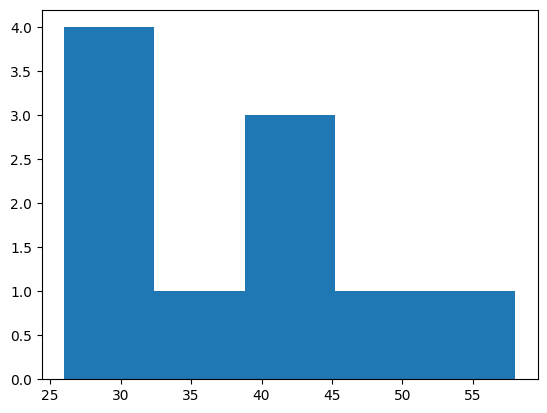

In [6]:
# plot histogram of peak ages
plt.hist(train_peaks - train_troughs, bins=5)

### Implementation

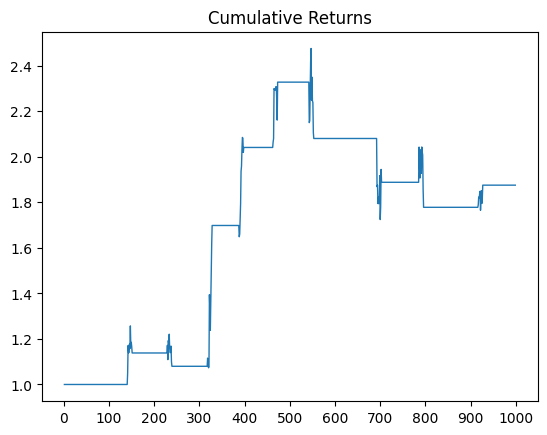

In [85]:
ndays= 10

train['positions'] = 0
train['ma_crossed'] = train.usd < train.ma_24

for i in range(len(train_troughs)-1):
    t1 = train_troughs[i]
    t2 = train_troughs[i+1] 

    ma_crossed_t1_t2 = train.ma_crossed[t1+median_peak_age:t2+1]
    if not ma_crossed_t1_t2.any():
        continue
    first_ma_crossed = ma_crossed_t1_t2[ma_crossed_t1_t2].index[0]
    train.loc[first_ma_crossed, 'positions'] = -1


train['positions'] = add_fixed_holding_periods(train.positions, ndays)
# shift positions to avoid lookahead bias
train['positions'] = train.positions.shift(1)

train['strategy_cumr'] = (train.positions * train.r + 1).cumprod()
train.strategy_cumr.plot(title='Cumulative Returns')
# set x-axis ticks
plt.xticks(range(0, len(train)+100, 100))
plt.show()

#### Debug

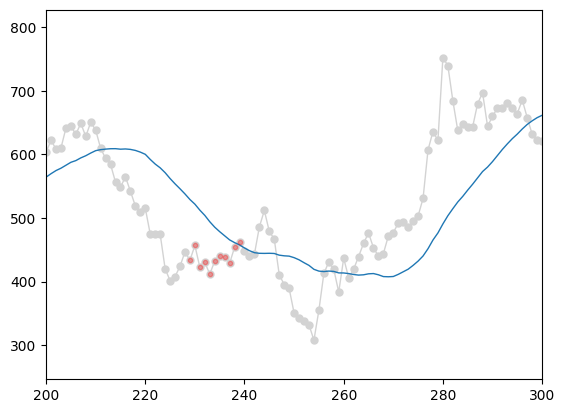

In [81]:
debug(train.usd, train.ma_24, train.positions, 200, 300)

Entry into a large drawdown, with a bounce back followed resulted in a loss.

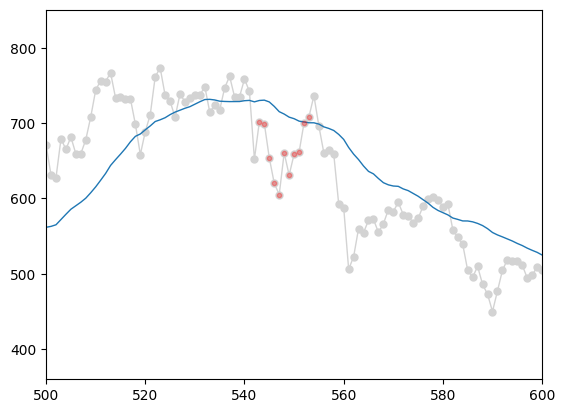

In [87]:
debug(train.usd, train.ma_24, train.positions, 500, 600)

False positive.

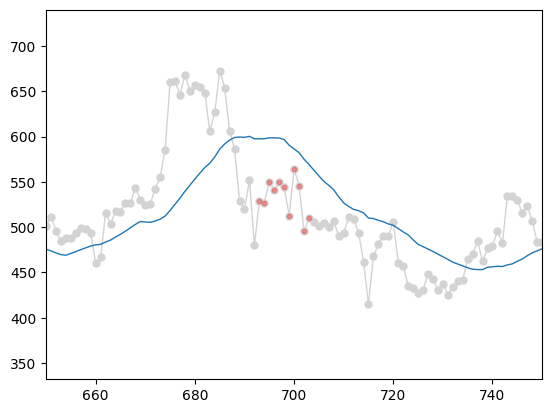

In [80]:
debug(train.usd, train.ma_24, train.positions, 650, 750)

Entry into a large drawdown, with a bounce back followed resulted in a loss.

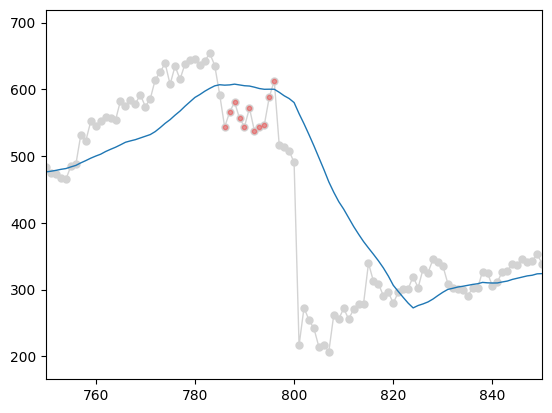

In [86]:
debug(train.usd, train.ma_24, train.positions, 750, 850)

False positive.